In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
#Transform: converts images to tensor and normalizes the pixel values (0-1)
transform = transforms.Compose([
    transforms.ToTensor(), #converts to tensor, shape [1, 28, 28]
    transforms.Normalize((0.5,), (0.5,)) #normalizs mean=0.5, std=0.5
])

#Download datasets
#Loads training dataset of 60000 images
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
#Loads test dataset of 10000 images
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

#Create data loaders
#Loads 64 images in each batch, weights adjusted after each batch 938 batches in one epoch and each epoch has a randomized order or images
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
#Loads 1000 images in each batch as no weight updates allow for larger batch sizes, and original order is kept allowing for reproducible results
val_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

#Each batch from train_loader has:
#  - images: tensor of shape [64, 1, 28, 28] 
#  - 64 images, each with 1 channel (grayscale) and size 28x28 pixels
#  - labels: tensor of shape [64] with integerl labes (0-9)
#When image is flattened, it becomes fully-connected layer
#image vector size is 28*28=784
#batch of 64 images, makes tensor of shape [64, 784]

In [3]:
#Building fully-connected nueral network
#Input:784 neurons (28*28 pixels)
#Hidden Layer: 128 neurons (with ReLu actiation)
#Output Layer: 10 neurons (one per digit 0-9)

class TwoLayerNet(nn.Module):
    #Constructor 
    def __init__(self):
        super(TwoLayerNet, self).__init__()
        #Stores first/input layer as attribute of network, .Linear creates fully-connected dense layer
        self.fc1 = nn.Linear(28*28, 128)
        #Stores second/output layer as attribute of network, produces final prediction scores(logits) for each digits
        self.fc2 = nn.Linear(128, 10)

    #Defines how data flows through network (forward pass)
    def forward(self, x):
        #Flattens 2D images into 1D vectors, Flatten: [64,1,28,28] -> [64,784]
        x = x.view(x.size(0), -1) #.size(0) gets and preserves batch size, -1 means Pytorch auto-calculates remaining dimensions
        x = torch.relu(self.fc1(x)) #Applies first linear layer, and then relu function onto outputs of first layer, outputs x with shape [64,128]
        x = self.fc2(x) #Applies second linear layer, outputs x with shape [64,10] (logits for each digit)
        return x #Final output tensor


In [4]:
#Determines whether to use GPU or CPU for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Creates instance of neural network, and moves model either to GPU or CPU
model = TwoLayerNet().to(device)

#Defines loss function, and CrossEntropy is chosen
#What it does:uses softmax to convert logits to probabilities, and then compares predicted to true labels
criterion = nn.CrossEntropyLoss() #good for multi-class classification

#Defines the optimization algorithm used to update weights during training
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [5]:
num_epochs = 5 #number of passes through entire dataset
train_losses = [] #Stores training loss for each epoch
val_losses = [] #Stores validation loss for each epoch

for epoch in range(num_epochs):
    model.train() #Sets model to training mode
    running_loss = 0.0 #sums up loss values for each epoch

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass (batch of 64 images)
        outputs = model(images)        # [64,10]
        loss = criterion(outputs, labels)

        # Backward + optimize
        optimizer.zero_grad() #Clears old gradients from previous step
        loss.backward() #Computes gradients 
        optimizer.step() #Updates all weights using gradients

        running_loss += loss.item()
    
    # Average training loss
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation phase
    model.eval() #Sets model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}") #Prints out values, formatted to 4 decimal places


Epoch [1/5], Train Loss: 0.3903, Val Loss: 0.2316
Epoch [2/5], Train Loss: 0.2032, Val Loss: 0.1675
Epoch [3/5], Train Loss: 0.1473, Val Loss: 0.1349
Epoch [4/5], Train Loss: 0.1172, Val Loss: 0.1191
Epoch [5/5], Train Loss: 0.1007, Val Loss: 0.1110


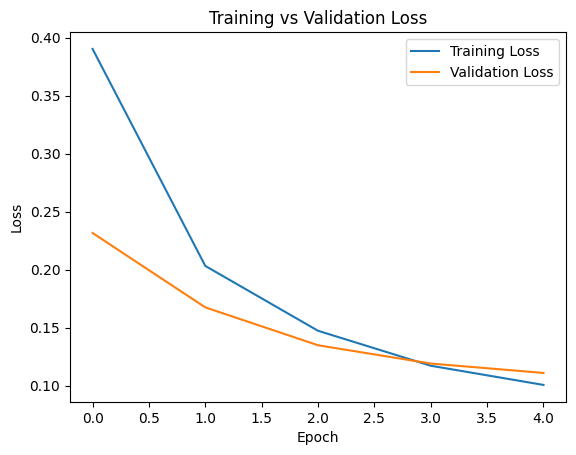

In [6]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()